In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, Flatten, Dense, Conv1D, LSTM, GRU, AveragePooling1D, Dropout, Bidirectional
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from corpora_utils import CorporaHelper, CorporaDomains, CorporaProperties
import numpy as np
import os
import pickle

In [57]:
"""
#Activate GPU
#WARNING GPU TAKES 5 TIMES LONGER THAN CPU! With Consul Project 1
#Check for GPU
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
# GPU CONFIG
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
"""

#Deactivate GPU
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [58]:
MULTIGENRE = 'muligenre'
TWITTER = 'twitter'
MG_AND_TWITTER = 'mg_and_twitter'

# set wich corpora to use Multigenre or twitter
use_mg_train_corpora = MULTIGENRE

In [59]:
# load data
train_labels = []
train_texts = []
test_labels = []
test_texts = []

In [60]:
def load_corpora(filepath, sep=';'):
    print('Load: ', filepath)
    corpora_helper = CorporaHelper(filepath, separator=sep)
    count_joy = 0
    count_sadness = 0
    count_anger = 0
    count_fear = 0
    labels = []
    texts = []
    # preprocessing corpora
    corpora_helper.translate_urls()
    corpora_helper.translate_emoticons()
    corpora_helper.translate_emojis()
    corpora_helper.translate_email()
    #corpora_helper.translate_mention()
    corpora_helper.translate_html_tags()
    #corpora_helper.translate_camel_case()
    corpora_helper.translate_underscore()

    corpora_helper.translate_string('-LRB-','(')
    corpora_helper.translate_string('-RRB-',')')
    corpora_helper.translate_string('`',"'") # ` to '
    corpora_helper.translate_string("''",'"') # double '' to "
    corpora_helper.translate_contractions()
    corpora_helper.translate_string("'","") # remove '
    corpora_helper.translate_string("\\n"," ") # replace new lines with space

    #corpora_helper.spell_correction()
    corpora_helper.add_space_at_special_chars()
    corpora_helper.add_space_at_special_chars(regexlist = r"([#])")
    #corpora_helper.translate_to_lower()

    # 0 anger
    # 1 fear
    # 2 joy
    # 3 sadness
    for index, corpus in corpora_helper.get_data().iterrows():
        if corpus[CorporaProperties.EMOTION.value] == 'anger':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(0)
            count_anger += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'fear':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(1)
            count_fear += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'joy':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(2)
            count_joy += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'sadness':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(3)
            count_sadness += 1
    print('number of anger labels: ',count_anger)
    print('number of fear labels: ', count_fear)
    print('number of joy labels: ', count_joy)
    print('number of sadness labels: ', count_sadness)
    print('----------------------------------------------------------------------')
    return texts, labels
    #max_data = count_anger + count_fear + count_joy + count_sadness


In [61]:
train_file = ""
test_file = ""
sep = ';'
word_embeddings_path = ''
if use_mg_train_corpora == MULTIGENRE:
    train_file = "corpora/multigenre_450_train.csv"
    test_file = "corpora/multigenre_450_test.csv"
    word_embeddings_path = 'custom_embedding/multi_embedding.pkl'
    sep = ';'
    print("Use MULTIGENRE train corpora")
elif use_mg_train_corpora == TWITTER:
    train_file = "corpora/twitter_2000_train.csv"
    test_file = "corpora/twitter_2000_test.csv"
    word_embeddings_path = 'custom_embedding/multi_embedding.pkl'
    sep = '\t'
    print("Use TWITTER train corpora")
else:
    train_file = "corpora/twitter_2000_mg_450_train.csv"
    test_file = "corpora/twitter_2000_mg_450_test.csv"
    word_embeddings_path = 'custom_embedding/multi_embedding.pkl'
    sep = '\t'
    print("Use TWITTER and MULTIGENRE train corpora")
    
train_texts, train_labels = load_corpora(train_file, sep=sep)
test_texts, test_labels = load_corpora(test_file, sep=sep)

Use MULTIGENRE train corpora
Load:  corpora/multigenre_450_train.csv
number of anger labels:  405
number of fear labels:  405
number of joy labels:  405
number of sadness labels:  405
----------------------------------------------------------------------
Load:  corpora/multigenre_450_test.csv
number of anger labels:  45
number of fear labels:  45
number of joy labels:  45
number of sadness labels:  45
----------------------------------------------------------------------


In [62]:
# Load prepared custom ensemble embedding
with open(word_embeddings_path, 'rb') as word_embeddings_file:
    embedding_info = pickle.load(word_embeddings_file)

In [63]:
# Embedding helper functions
def is_active_vector_method(string):
    return int(string)
    
def get_unigram_embedding(word, word_embedding_dict, bin_string):
    
    if word in word_embedding_dict:
        word_feature_embedding_dict = word_embedding_dict[word]
        final_embedding = np.array([])
    else:
        return None
    
    for i in range(16):
        if is_active_vector_method(bin_string[i]):
            final_embedding = np.append(final_embedding, word_feature_embedding_dict[i])
    
    return final_embedding

In [64]:
pre_padding = 0
embeddings_index = embedding_info[0]
MAX_SEQUENCE_LENGTH = embedding_info[1]
maxlen = MAX_SEQUENCE_LENGTH
print("maxlen: ",maxlen)
#MAX_NB_WORDS = 10000

maxlen:  100


# Selection Unigram Features

In [65]:
# selecting relevant embeddings for multigenre
if use_mg_train_corpora == MULTIGENRE:
    # Multigenre
    unigram_feature_string = "1001111111111101"
elif use_mg_train_corpora == TWITTER:
    # Twitter
    unigram_feature_string = "0110001111111101"
    unigram_feature_string = "1111111111111111"
else:
    # Twitter and Multigenre
    unigram_feature_string = "1110010000000000"
# 1 Google news pretrained vectors : GoogleNews-vectors-negative300.bin.gz  
# 2 Twitter pretrained vectors: word2vec_twitter_model.bin
# 3 glove.twitter.27B.200d.txt
# 4 glove.6B.300d.txt
# 5 glove.42B.300d.txt
# 6 glove.840B.300d.txt
# 7 NRC Emotion Intensity Lexicon
# 8 senti word net
#9  NRC Sentiment lexicon: NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
#10 lexicons/Emoticon-unigrams.txt
#11 lexicons/Emoticon-AFFLEX-NEGLEX-unigrams.txt
#12 NRC Hashtag Lexica: NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
#13 HS-unigrams.txtNRC-Hashtag-Emotion-Lexicon-v0.2.txt
#14 HS-AFFLEX-NEGLEX-unigrams.txt
#15 Emoji Polarities
#16 Depeche mood

In [66]:
"""
Deep learning with multigenre and twitter corpus and 4 emotions
"""
# K-Fold variables
num_folds = 3 # 10
fold_runs = 2 # 3
fold_no = 1
# train
epochs = 4
max_words = 20000
# max. different words:
# Multigerne: 5140  => 10000 or 3000 or 1000 ?
# Twitter: 17580 => 20000 or 10000 ?
# MG and Twitter: 20073 => evtl. 20000?
#optimizer = keras.optimizers.Adam(learning_rate=0.01)
optimizer = Adam(learning_rate=0.001) # default 0.001
skfold = StratifiedKFold(n_splits = num_folds, random_state = 7, shuffle = True)
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
avg_acc_per_run = []
avg_loss_per_run = []
avg_precision_per_run = []
avg_recall_per_run = []
avg_f1_per_run = []
create_final_model = True
# run only final model without kfold
run_final_train_only = False

In [67]:
EMBEDDING_DIM = len(get_unigram_embedding("glad", embedding_info[0], unigram_feature_string))
print("Embedding dimension:",EMBEDDING_DIM)


tokenizer = Tokenizer(num_words=max_words, filters = '')

Embedding dimension: 1560


In [68]:
# Create train an test data set
def create_data(texts, labels, maxlen):
    ## Create one hot encoding
    #max_words = 10000
    #maxlen = 100 # max. number of words in sequences
    #tokenizer = Tokenizer(num_words=max_words, filters = '')
    #tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    #word_i = tokenizer.word_index

    data = pad_sequences(sequences, maxlen=maxlen)

    labels_arr = np.asarray(labels)
    print('Shape of data:', data.shape)
    print('Shape of labels:', labels_arr.shape)
    print('-------------------------------------------')

    # mix the data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels_arr = labels_arr[indices]

    # split in train and validate
    x_data = data
    y_data = labels_arr
    return x_data, y_data

In [69]:
# fit tokenizer
all_texts = train_texts.copy()
all_texts.append(test_texts.copy())
tokenizer.fit_on_texts(all_texts)

In [70]:
# Train an word index for embedding enrichment
x_train, y_train = create_data(train_texts, train_labels, maxlen)
x_test, y_test = create_data(test_texts, test_labels, maxlen)
word_index = tokenizer.word_index
x_train_copy = x_train.copy()
y_train_copy = y_train.copy()
print ('%s unique Tokens found.' % len(word_index))

Shape of data: (1620, 100)
Shape of labels: (1620,)
-------------------------------------------
Shape of data: (180, 100)
Shape of labels: (180,)
-------------------------------------------
5140 unique Tokens found.


In [71]:
# Build Matrix
word_embedding_matrix = list()
word_embedding_matrix = np.zeros((max_words, EMBEDDING_DIM))
#word_embedding_matrix.append(np.zeros(EMBEDDING_DIM))

In [72]:
for word, i in word_index.items(): # sorted(word_indices, key=word_indices.get):
    embedding_features = get_unigram_embedding(word, embedding_info[0], unigram_feature_string)
    if i < max_words:
        if embedding_features is not None:
            # Words not found in embedding index will be all-zeros.
            word_embedding_matrix[i] = embedding_features

word_embedding_matrix = np.asarray(word_embedding_matrix, dtype='f')
word_embedding_matrix = scale(word_embedding_matrix)

C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [73]:
#print('word_indices_len',word_indices_len)
print('EMBEDDING_DIM',EMBEDDING_DIM)
print('input_length', MAX_SEQUENCE_LENGTH + pre_padding)
embedding = Embedding(max_words, EMBEDDING_DIM, input_length=maxlen, trainable=False)
#embedding = Embedding(word_indices_len + 1, EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH + pre_padding, trainable=False)

EMBEDDING_DIM 1560
input_length 100


# Running "optimal" BiLSTM Model with 3 Runs and 10 k-Folds

In [74]:

def create_model():
    # Create model
    model = Sequential()
    model.add(embedding)
    model.add(Bidirectional(LSTM(32, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)))   
    model.add(Dense(16, activation='relu'))   
    model.add(layers.GlobalMaxPooling1D())
    model.add(Dense(4, activation='softmax'))


    return model


# Run the Model

------------------------------------------------------------------------
Training for fold 1 ind run 1 ...
Train on 1080 samples, validate on 540 samples
Epoch 1/4
1080/1080 [==============================] - 7s 7ms/step - loss: 1.5008 - acc: 0.2593 - val_loss: 1.3444 - val_acc: 0.3296
Epoch 2/4
1080/1080 [==============================] - 7s 7ms/step - loss: 1.2751 - acc: 0.4361 - val_loss: 1.1573 - val_acc: 0.5630
Epoch 3/4
1080/1080 [==============================] - 7s 7ms/step - loss: 1.0895 - acc: 0.6065 - val_loss: 0.9662 - val_acc: 0.6444
Epoch 4/4
540/540 [==============================] - 2s 3ms/step
Score for fold 1: loss of 0.8445408949145564; accuracy of 68.70370507240295%
540/540 [==============================] - 2s 3ms/step
------------------------------------------------------------------------
Training for fold 2 ind run 1 ...
Train on 1080 samples, validate on 540 samples
Epoch 1/4
1080/1080 [==============================] - 9s 8ms/step - loss: 1.5265 - acc: 0.2972 

------------------------------------------------------------------------
Training for final model ...
Train on 1620 samples, validate on 180 samples
Epoch 1/4
1620/1620 [==============================] - 10s 6ms/step - loss: 1.4088 - acc: 0.3296 - val_loss: 1.0924 - val_acc: 0.5667
Epoch 2/4
1620/1620 [==============================] - 8s 5ms/step - loss: 1.0958 - acc: 0.5327 - val_loss: 0.8967 - val_acc: 0.6722
Epoch 3/4
1620/1620 [==============================] - 8s 5ms/step - loss: 0.8877 - acc: 0.6432 - val_loss: 0.7894 - val_acc: 0.7167
Epoch 4/4
1620/1620 [==============================] - 8s 5ms/step - loss: 0.7298 - acc: 0.7210 - val_loss: 0.7109 - val_acc: 0.7389
Evaluate final model on test data
180/180 [==============================] - 1s 3ms/step
test loss, test acc: [0.7108617610401577, 0.7388888597488403]


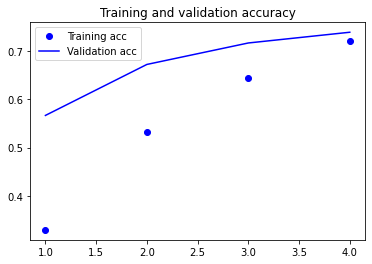

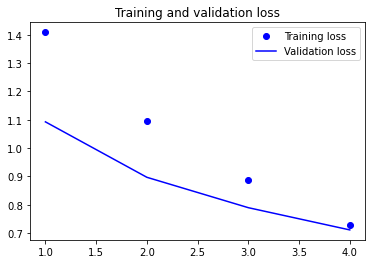

In [75]:
# run x Times the folds
if not run_final_train_only:
    for run_num in range(1,fold_runs+1):
        # k-fold
        for train_ind, val_ind in skfold.split(x_train,y_train):

            # Create model
            model = create_model()

            # Load GloVe embedding
            model.layers[0].set_weights([word_embedding_matrix])
            model.layers[0].trainable = False

            # Train and Evaluate
            model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['acc'])
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ind run {run_num} ...')

            history = model.fit(x_train[train_ind], y_train[train_ind],
                                epochs=epochs,
                                batch_size=64,
                                verbose=1,
                                validation_data=(x_train[val_ind], y_train[val_ind]))

            # metrics
            scores = model.evaluate(x_train[val_ind], y_train[val_ind], batch_size=32)
            #print(f'Score for fold {fold_no}: {model.metrics_name[0]} of {scores[0]}; {model.metrics_name[1]} of {scores[1]*100}%')
            print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
            acc_per_fold.append(scores[1]*100)
            loss_per_fold.append(scores[0])

            # Evaluation metrics precison recall f1
            y_pred = model.predict(x_train[val_ind], batch_size=64, verbose=1)
            y_pred_bool = np.argmax(y_pred, axis=1)
            precision, recall, f1, support = precision_recall_fscore_support(y_train[val_ind], y_pred_bool)
            mean_precision = np.mean(precision)
            mean_recall = np.mean(recall)
            mean_f1 = np.mean(f1)
            precision_per_fold.append(mean_precision)
            recall_per_fold.append(mean_recall)
            f1_per_fold.append(mean_f1)

            fold_no += 1

        # == Provide average scores ==
        print('------------------------------------------------------------------------')
        print('Score per fold')
        for i in range(0, len(acc_per_fold)):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        avg_acc_per_run.append(np.mean(acc_per_fold))
        avg_loss_per_run.append(np.mean(loss_per_fold))
        avg_precision_per_run.append(np.mean(precision_per_fold))
        avg_recall_per_run.append(np.mean(recall_per_fold))
        avg_f1_per_run.append(np.mean(f1_per_fold))

        print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print(f'> Precision: {np.mean(precision_per_fold)}')
        print(f'> Recall: {np.mean(recall_per_fold)}')
        print(f'> F1: {np.mean(f1_per_fold)}')
        print('------------------------------------------------------------------------')

        # reset fold vars
        acc_per_fold = []
        loss_per_fold = []
        precision_per_fold = []
        recall_per_fold = []
        f1_per_fold = []
        fold_no = 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score for k-fold runs')
    for i in range(0, len(avg_acc_per_run)):
        print('------------------------------------------------------------------------')
        print(f'> Run {i+1} Fold averages - Loss: {avg_loss_per_run[i]} - Accuracy: {avg_acc_per_run[i]}% ')
        print(f'> Run {i+1} Fold averages - Precision: {avg_precision_per_run[i]} - Recall: {avg_recall_per_run[i]} F1: {avg_f1_per_run[i]}')
    print('------------------------------------------------------------------------')
    print(f'Overall average scores for all {fold_runs} runs:')
    print(f'> Accuracy: {np.mean(avg_acc_per_run)} (+- {np.std(avg_acc_per_run)})')
    print(f'> Loss: {np.mean(avg_loss_per_run)}')
    print(f'> Precision: {np.mean(avg_precision_per_run)}')
    print(f'> Recall: {np.mean(avg_recall_per_run)}')
    print(f'> F1: {np.mean(avg_f1_per_run)}')
    print('------------------------------------------------------------------------')

# create final model #Todo sync with fold rund
if create_final_model:
    model = create_model()
    model.summary()

    # Load GloVe embedding
    model.layers[0].set_weights([word_embedding_matrix])
    model.layers[0].trainable = False

    # Train and Evaluate
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
    print('------------------------------------------------------------------------')
    print('Training for final model ...')

    history = model.fit(x_train_copy, y_train_copy,
                        epochs=epochs,
                        batch_size=64,
                        verbose=1,
                        validation_data=(x_test, y_test))
    # Save Model
    if use_mg_train_corpora == MULTIGENRE:
        model.save('models/model_emotion_detection_multigenre.h5')
        pickle.dump(tokenizer, open("models/tokenizer_multigenre.pkl", "wb"))
    elif use_mg_train_corpora == TWITTER:
        model.save('models/model_emotion_detection_twitter.h5')
        pickle.dump(tokenizer, open("models/tokenizer_twitter.pkl", "wb"))
    else:
        model.save('models/model_emotion_detection_multigenre_twitter.h5')
        pickle.dump(tokenizer, open("models/tokenizer_multigenre_twitter.pkl", "wb"))

    # Test final model
    print("Evaluate final model on test data")
    results = model.evaluate(x_test, y_test, batch_size=128)
    print("test loss, test acc:", results)
    # For Model evaluation metrics run evalModel

    # Plot performance
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()